In [125]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature # milyen tulajdonság szerint bontunk
        self.threshold = threshold  # milyen küszöbértékkel bontunk
        self.left = left # bal oldali gyerek
        self.right = right # jobb oldali gyerek
        self.value = value # érték, ha levélcsomópont
        
    def is_leaf_node(self):
        #ha van értéke, akkor levélcsomópont
        return self.value is not None
    
    def disp(self):
        print(f"\n\nNode:\nfeature",self.feature, "\t\ntreshold", self.threshold,"\t\nvalue", self.value, "\nleft", self.left, "\nright", self.right, sep='\t')
        if self.left is not None:
            print("LEFT side")
            self.left.disp()
        if self.right is not None:
            print("RIGHT side")
            self.right.disp()

class DecisionTree:
    #max_depth: REQUIRED - maximális mélység
    #min_samples_split: REQUIRED - minimális mintaszám, hogy egy csomópontot szétválasszunk
    #min_samples_leaf: REQUIRED - minimális mintaszám, hogy egy csomópont levél legyen
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf = 1, number_of_features_used=None, random_state=None, split_criterion="information_gain"):
        self.min_samples_split=min_samples_split # minimális mintaszám, hogy egy csomópontot szétválasszunk
        self.max_depth=max_depth # fa maximális mélysége
        self.number_of_features_used=number_of_features_used # mennyi attribútumot használunk a legjobb bontáshoz, attribútumok egy részhalmaza
        self.min_samples_leaf=min_samples_leaf # minimális mintaszám, hogy egy csomópont levél legyen
        self.random_state=random_state # random szám generálásához használt seed, reprodukálhatóság miatt
        self.split_criterion = split_criterion # bontási kritérium, mse vagy information_gain
        self.root=None

    #Modeel tanítása
    def fit(self, X, y):
        # Hiányzó értékek pótlása
        mean = np.nanmean(X, axis=0)  # Oszlopok átlaga (kivéve a hiányzó értékeket)
        indexs = np.where(np.isnan(X))  # Hiányzó értékek helyei
        X[indexs] = np.take(mean, indexs[1])

        self.number_of_features_used = X.shape[1] if not self.number_of_features_used else min(X.shape[1],self.number_of_features_used) # ha paraméterként nem adtuk meg semmit, akkor az összes attribútumot használjuk, egyébként a 2 minimumát
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        #rekurzív bontás a legjobb bontással
        number_of_samples, number_of_features = X.shape #mintaszám, attribútumok száma
        number_of_labels = len(np.unique(y)) #ha ez egy akkor már nem bontjuk tovább -> levélcsomópont
        
        # 1.) Leállási feltételek
        if (depth>=self.max_depth 
            or number_of_labels==1 
            or number_of_samples<self.min_samples_split
            or number_of_samples < self.min_samples_leaf):
            # ha bármelyik feltétel teljesül, akkor levélcsomópontnál tartunk
            # a levélcsomópont értéke a leggyakoribb osztály lesz
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        #random_seed beállítása, ha meg lett adva, reprodukálhatóság miatt
        if self.random_state is not None:
            np.random.seed(self.random_state) #random seed beállítása

        features_randomly_chosen = np.random.choice(number_of_features, self.number_of_features_used, replace=False)
        #print("features_randomly_chosen: ", features_randomly_chosen)

        # 2.) Legjobb bontás keresése
        best_feature, best_threshold = self._best_split(X, y, features_randomly_chosen) #visszatér a legjobb attribútummal és küszöbértékkel
        #print(best_feature)
        # 3.) Gyermekek létrehozása és rekurzív hívás
        left_indexs, right_indexs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_indexs, :], y[left_indexs], depth+1)
        right = self._grow_tree(X[right_indexs, :], y[right_indexs], depth+1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)
    
    #A leggyakoribb érték meghatározása
    def _most_common_label(self, y):
        counter = Counter(y)
        """print("Counter: ", counter)
        print("Counter.most_common(1): ", counter.most_common(1))
        print("Counter.most_common(1)[0]: ", counter.most_common(1)[0])
        print("Counter.most_common(1)[0][0]: ", counter.most_common(1)[0][0])"""
        value = counter.most_common(1)[0][0] # leggyakoribb érték
        return value

    #legjobb vágás keresése
    def _best_split(self, X, y, features_randomly_chosen):
        best_criterion = None
        split_index, split_threshold = None, None

        for feature_index in features_randomly_chosen:  #végigmenünk az összes kiválasztott elemen
            X_column = X[:, feature_index]#végigpróbáljuk az összes attribútumot 0->random feature index
            thresholds = np.unique(X_column)
            #print("Thresholds: ", thresholds)

            for threshold in thresholds:
                # minden egyes küszöbértéknél kiszámoljuk a bontás kritériumát
                criterion = self._split_criterion(y, X_column, threshold)

                if best_criterion is None or criterion > best_criterion: #ha nincs még legjobb kritérium vagy a mostani jobb, akkor frissítjük
                    best_criterion = criterion
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold

    #lehetséges vágási kritériumok használata
    def _split_criterion(self, y, X_column, threshold):
        if self.split_criterion == "information_gain":
            return self._information_gain(y, X_column, threshold)
        elif self.split_criterion == "mse":
            return self._mean_squared_error(y, X_column, threshold)
        else:
            raise ValueError("Invalid split criterion!")

    #MSE kritérium számítása - TODO: átnézni
    def _mean_squared_error(self, y, X_column, threshold):
        left_idxs, right_idxs = self._split(X_column, threshold)
        left_values = y[left_idxs]
        right_values = y[right_idxs]
        left_mean = np.mean(left_values)
        right_mean = np.mean(right_values)
        mse = np.mean((left_values - left_mean) ** 2) + np.mean((right_values - right_mean) ** 2)
        return mse
    
    #TODO: átnézni
    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_indexs, right_indexs = self._split(X_column, threshold)

        if len(left_indexs) == 0 or len(right_indexs) == 0:
            return 0
        
        # calculate the weighted avgerage entropy of children
        number_of_samples = len(y)
        number_of_samples_left, number_of_samples_right = len(left_indexs), len(right_indexs)
        entropy_left, entorpy_right = self._entropy(y[left_indexs]), self._entropy(y[right_indexs])
        child_entropy = (number_of_samples_left/number_of_samples) * entropy_left + (number_of_samples_right/number_of_samples) * entorpy_right

        # calculate the information gain
        information_gain = parent_entropy - child_entropy
        return information_gain

    #TODO: átnézni
    def _entropy(self, y):
        histogram = np.bincount(y) #occurence of each class
        ps = histogram / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    #TODO: átnézni
    def _split(self, X_column, split_threshold):
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs
    
    #For predicting the output - TODO: átnézni
    def predict(self, X):
        print([self._traverse_tree(x, self.root) for x in X])
        return np.array([self._traverse_tree(x, self.root) for x in X])

    #TODO: átnézni
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            #print("Levél value: ", node.value, "treshold: ",node.threshold, "feature: ",node.feature)
            return node.value

        if x[node.feature] <= node.threshold:
            #print("Csomopont")
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    #Fa kiíratása
    def print(self):
        self.root.disp()
        pass

    #Fa másfajta megjeeelenítése
    def print_tree(self):
        self._print_node(self.root)

    #TODO: átnézni
    def _print_node(self, node, indent=''):
        if node is None:
            return

        if node.is_leaf_node():
            print(indent + f"Leaf: {node.value}")
        else:
            print(indent + f"Feature {node.feature} <= {node.threshold} ?")
            print(indent + "--> True:")
            self._print_node(node.left, indent + "    ")
            print(indent + "--> False:")
            self._print_node(node.right, indent + "    ")

    def plot_tree_the_second(self, node, depth, x_offset, y_offset, x_scale):
        if node.is_leaf_node():
            value = node.value
            plt.text(x_offset, y_offset, f'Value: {value:.2f}', fontsize=12, ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        else:
            feature = node.feature
            threshold = node.threshold
            left_child = node.left
            right_child = node.right

            plt.text(x_offset, y_offset, f'Feature {feature}\n<= {threshold:.2f}', fontsize=12, ha='center',
                    va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

            # Calculate the positions of the next nodes and connect them
            next_y_offset = y_offset - 1
            next_x_offset_left = x_offset - x_scale / (2 ** (depth + 1))
            next_x_offset_right = x_offset + x_scale / (2 ** (depth + 1))

            plt.plot([x_offset, next_x_offset_left], [y_offset, next_y_offset], 'k-')
            plt.plot([x_offset, next_x_offset_right], [y_offset, next_y_offset], 'k-')
            

            self.plot_tree_the_second(left_child, depth + 1, next_x_offset_left, next_y_offset, x_scale)
            self.plot_tree_the_second(right_child, depth + 1, next_x_offset_right, next_y_offset, x_scale)


(1599, 12)


{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]
Accuracy:  0.9473684210526315
Feature 27 <= 0.1423 ?
--> True:
    Feature 22 <= 107.4 ?
    --> True:
        Feature 18 <= 0.01647 ?
        --> True:
            Leaf: 1
        --> False:
            Leaf: 1
    --> False:
        Feature 21 <= 19.58 ?
        --> True:
            Leaf: 1
        --> False:
            Leaf: 0
--> False:
    Feature 22 <= 112.5 ?
    --> True:
        Feature 24 <= 0.1624 ?
        --> True:
            Leaf: 1
        --> False:
            Leaf: 0
    --> False:
        Leaf: 0


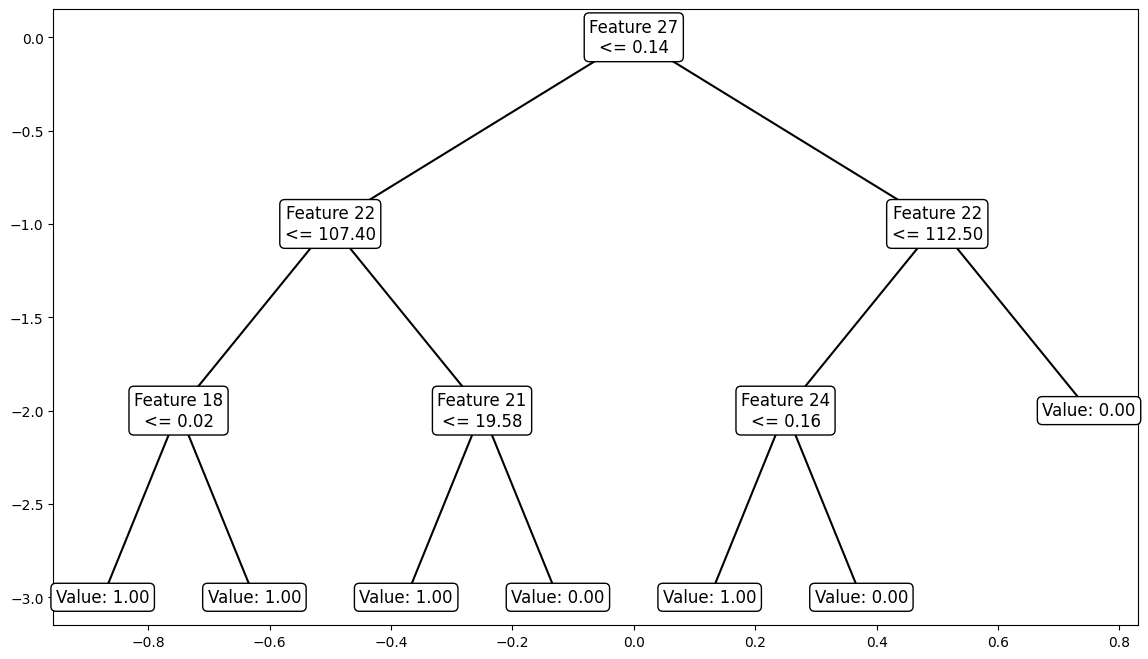

In [126]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd

#Minta adatforrás
df = pd.read_csv("winequality-red.csv")
print(df.shape)
#display(df.head())
#X = df[df.columns[:-1]].values
#y = df[df.columns[:-1]].values

wine = datasets.load_breast_cancer()
display(wine)
X = wine.data # adatok
y = wine.target # címkék/célváltozók

#display(X)
display(X.shape)
display(y.shape)


# Előkészítsük a bemeneti adatokat és a címkéket
#X = np.array([[1, 2, 3], [4, np.nan, 6], [7, 8, 9]])# Példa bemeneti adatok (a második adat hiányzó értéket tartalmaz)
#y = np.array([0, 1, 0]) # Példa címkék



#Adatok felosztása tanító és tesztelő halmazra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 80% tanító, 20% tesztelő

#Döntési fa tanítása
decision_tree = DecisionTree(max_depth=3, split_criterion="information_gain", random_state=0)
decision_tree.fit(X_train, y_train)

#Döntési fa kiértékelése
y_pred = decision_tree.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, y_pred)
print("Accuracy: ", acc)

decision_tree.print_tree()
plt.figure(figsize=(14, 8))
decision_tree.plot_tree_the_second(decision_tree.root, 0, 0, 0, 1)

#dt.print()